# EEG Motor Movement/Imagery Classification Using Random Forest and Convolutional Neural Networks

### Imports

In [15]:
import os
import numpy as np
import mne
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import detrend
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import itertools
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

### Getting .env variables

In [2]:
load_dotenv()

INPUT_DIR = os.getenv("INPUT_DIR", "./data/raw")
OUTPUT_DIR = os.getenv("OUTPUT_DIR", "./result")

SFREQ = int(os.getenv("SFREQ", 160))
WINDOW_SEC = float(os.getenv("WINDOW_SEC", 2))
OVERLAP = float(os.getenv("OVERLAP", 0.5))

DEBUG = os.getenv("DEBUG", "1").strip().lower() in {"1", "true", "yes", "y"}
# DEBUG = False
print(f"DEBUGGING is {'ON' if DEBUG else 'OFF'}")

DEBUGGING is ON


In [3]:
window_samples = int(SFREQ * WINDOW_SEC)
print(f"Window samples: {window_samples}")

records_file = os.path.join(INPUT_DIR, "RECORDS")
print(f"Records file: {records_file}")

Window samples: 320
Records file: ./data/raw/RECORDS


## 1. Data Preparation

This data set consists of over 1500 one- and two-minute EEG recordings, obtained from 109 volunteers, as described below.

Subjects performed different motor/imagery tasks while 64-channel EEG were recorded using the BCI2000 system (http://www.bci2000.org). 

The experimental runs were:
1. Baseline, eyes open
2. Baseline, eyes closed
3. Task 1 (open and close left or right fist)
4. Task 2 (imagine opening and closing left or right fist)
5. Task 3 (open and close both fists or both feet)
6. Task 4 (imagine opening and closing both fists or both feet)
7. Task 1
8. Task 2
9. Task 3
10. Task 4
11. Task 1
12. Task 2
13. Task 3
14. Task 4

Each annotation includes one of three codes (**T0**, **T1**, or **T2**):
- **T0** corresponds to rest
- **T1** corresponds to onset of motion (real or imagined) of
    the left fist (in runs 3, 4, 7, 8, 11, and 12)
    both fists (in runs 5, 6, 9, 10, 13, and 14)
- **T2** corresponds to onset of motion (real or imagined) of
    the right fist (in runs 3, 4, 7, 8, 11, and 12)
    both feet (in runs 5, 6, 9, 10, 13, and 14)

### 1.1. Loading RECORDS file and verifying EDF files' existence

In [4]:
with open(records_file, "r") as f:
    records = [line.strip() for line in f if line.strip()]

print(f"Number of RECORDS entries: {len(records)}")
for r in records[:4]:
    print(" ", r)
print("  ...\n ",records[-1])

edf_paths = []
missing = []

for rel in records:
    p = os.path.join(INPUT_DIR, rel)
    if os.path.exists(p):
        edf_paths.append(p)
    else:
        missing.append(p)

print(f"\nResolved EDF files: {len(edf_paths)}")
print(f"Missing EDF files: {len(missing)}")

if missing:
    print("Example missing path:", missing[0])

Number of RECORDS entries: 1526
  S001/S001R01.edf
  S001/S001R02.edf
  S001/S001R03.edf
  S001/S001R04.edf
  ...
  S109/S109R14.edf

Resolved EDF files: 1526
Missing EDF files: 0


### 1.2. Testing [first] EDF file loading and preprocessing

In [5]:
if DEBUG:
    test_edf = edf_paths[0]
    print("Testing EDF:", test_edf)

    raw = mne.io.read_raw_edf(test_edf, preload=False, verbose=False)

    print("\n--- EDF INFO ---")
    print("Channels:", len(raw.ch_names))
    print("Sampling freq:", raw.info["sfreq"])
    print("Duration (sec):", raw.times[-1])
    print("First 10 channels:", raw.ch_names[:10])

    assert len(raw.ch_names) >= 64, "Expected ~64 EEG channels"
    assert abs(raw.info["sfreq"] - SFREQ) < 1e-3, "Sampling frequency mismatch"

Testing EDF: ./data/raw/S001/S001R01.edf

--- EDF INFO ---
Channels: 64
Sampling freq: 160.0
Duration (sec): 60.99375
First 10 channels: ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..']


### 1.3. Preprocessing All EDF Files and Saving Processed Data

In [6]:
def load_and_summarize(edf_path: Path):
    raw = mne.io.read_raw_edf(edf_path, preload=False, verbose=False)
    descs = sorted(map(str, set(raw.annotations.description))) if raw.annotations is not None else []
    print("\n===", edf_path.name, "===")
    print("sfreq:", raw.info["sfreq"], "| duration:", raw.times[-1], "sec | ch:", len(raw.ch_names))
    print("Annotations count:", len(raw.annotations))
    print("Unique descriptions:", descs)

    events, event_id = mne.events_from_annotations(raw, verbose=False)
    event_id = {str(k): v for k, v in event_id.items()}
    print("event_id:", event_id)
    print("n_events:", len(events))
    print("first events:", events[:10])
    return raw, events, event_id

if DEBUG:
    raw, events, event_id = load_and_summarize(Path(test_edf))
else:
    for edf in edf_paths:
        raw, events, event_id = load_and_summarize(Path(edf))


=== S001R01.edf ===
sfreq: 160.0 | duration: 60.99375 sec | ch: 64
Annotations count: 1
Unique descriptions: ['T0']
event_id: {'T0': 1}
n_events: 1
first events: [[0 0 1]]


### 1.4. Imaging vs. Execution Labeling

In [7]:
RUN_MOTOR_MOVE = {3, 5, 7, 9, 11, 13}
RUN_MOTOR_IMAG = {4, 6, 8, 10, 12, 14}

def run_id_from_filename(fname: str):
    # "S001R03.edf" -> 3
    return int(fname.split("R")[1].split(".")[0])

def get_exec_imag_label(run_id: int):
    # 0 = executed, 1 = imagined
    if run_id in RUN_MOTOR_MOVE:
        return 0
    if run_id in RUN_MOTOR_IMAG:
        return 1
    return -1

### 1.5. Window Segmentation and Normalization

In [8]:
def segment_windows(data: np.ndarray, window_samples: int, overlap: float):
    step = int(window_samples * (1 - overlap))
    windows = []
    for start in range(0, data.shape[1] - window_samples + 1, step):
        windows.append(data[:, start:start + window_samples])
    return np.asarray(windows)

def normalize_windows(windows: np.ndarray):
    mean = windows.mean(axis=2, keepdims=True)
    std = windows.std(axis=2, keepdims=True) + 1e-8
    return (windows - mean) / std

def extract_rf_features(windows: np.ndarray):
    means = windows.mean(axis=2)
    stds = windows.std(axis=2)
    rms = np.sqrt((windows**2).mean(axis=2))
    energy = (windows**2).sum(axis=2)
    return np.concatenate([means, stds, rms, energy], axis=1)

def pick_motor_intervals_from_annotations(raw):
    intervals = []
    if raw.annotations is None or len(raw.annotations) == 0:
        return intervals

    for onset, duration, desc in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
        d = str(desc)
        if d in {"T1", "T2"} and float(duration) > 0:
            intervals.append((float(onset), float(onset + duration), d))
    return intervals

def windows_from_intervals(data: np.ndarray, sfreq: float, intervals, window_samples: int, overlap: float):
    step = int(window_samples * (1 - overlap))
    all_windows = []
    meta = []

    for (t0, t1, desc) in intervals:
        start = int(round(t0 * sfreq))
        end = int(round(t1 * sfreq))

        if end - start < window_samples:
            continue

        for s in range(start, end - window_samples + 1, step):
            all_windows.append(data[:, s:s + window_samples])
            meta.append({"desc": desc, "start_sample": s, "end_sample": s + window_samples})

    if not all_windows:
        return np.empty((0, data.shape[0], window_samples), dtype=np.float32), []

    return np.asarray(all_windows, dtype=np.float32), meta

### 1.6. Segment recordings into fixed-length time windows, normalize signals, and select hand-related motor execution and imagery trials.

In [9]:
X_cnn_list, y_list, X_rf_list, meta_rows = [], [], [], []

n_channels_ref = None

for edf_path in edf_paths:
    edf_path = Path(edf_path)
    run_id = run_id_from_filename(edf_path.name)
    label = get_exec_imag_label(run_id)
    if label == -1:
        continue

    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
    raw.pick("eeg")

    if abs(raw.info["sfreq"] - SFREQ) > 1e-3:
        raw.resample(SFREQ)

    data = raw.get_data()

    if n_channels_ref is None:
        n_channels_ref = data.shape[0]

    if data.shape[0] != n_channels_ref:
        if DEBUG:
            print(f"Skipping {edf_path.name}: channels {data.shape[0]} != {n_channels_ref}")
        continue

    intervals = pick_motor_intervals_from_annotations(raw)  # T1/T2 only
    if not intervals:
        continue

    windows, wmeta = windows_from_intervals(
        data=data,
        sfreq=raw.info["sfreq"],
        intervals=intervals,
        window_samples=window_samples,
        overlap=OVERLAP,
    )
    if windows.shape[0] == 0:
        continue

    windows = normalize_windows(windows).astype(np.float32)
    feats = extract_rf_features(windows).astype(np.float32)

    X_cnn_list.append(windows)
    y_list.append(np.full((windows.shape[0],), label, dtype=np.int64))
    X_rf_list.append(feats)

    subject = edf_path.parent.name
    for md in wmeta:
        meta_rows.append({
            "subject": subject,
            "run": run_id,
            "exec_imag": int(label),
            "trial_type": md["desc"], # T1/T2
            "start_sample": md["start_sample"],
            "end_sample": md["end_sample"],
            "edf": str(edf_path),
        })

    if DEBUG:
        print(f"{edf_path.name}: intervals={len(intervals)} windows={windows.shape[0]} label={label}")

# stack
if X_cnn_list:
    X_cnn = np.vstack(X_cnn_list)
    y = np.concatenate(y_list)
    X_rf = np.vstack(X_rf_list)
else:
    X_cnn = np.empty((0, n_channels_ref or 64, window_samples), dtype=np.float32)
    y = np.empty((0,), dtype=np.int64)
    X_rf = np.empty((0, (n_channels_ref or 64) * 4), dtype=np.float32)

meta = pd.DataFrame(meta_rows)

print("X_cnn:", X_cnn.shape)
print("y:", y.shape, "counts:", np.bincount(y) if y.size else "empty")
print("X_rf:", X_rf.shape)
print("meta:", meta.shape)

# save
np.save(os.path.join(OUTPUT_DIR, "X_cnn.npy"), X_cnn)
np.save(os.path.join(OUTPUT_DIR, "y.npy"), y)
np.save(os.path.join(OUTPUT_DIR, "X_rf.npy"), X_rf)
meta.to_csv(os.path.join(OUTPUT_DIR, "meta.csv"), index=False)

print("Saved to:", OUTPUT_DIR)

S001R03.edf: intervals=15 windows=45 label=0
S001R04.edf: intervals=15 windows=45 label=1
S001R05.edf: intervals=15 windows=45 label=0
S001R06.edf: intervals=15 windows=45 label=1
S001R07.edf: intervals=15 windows=45 label=0
S001R08.edf: intervals=15 windows=45 label=1
S001R09.edf: intervals=15 windows=45 label=0
S001R10.edf: intervals=15 windows=45 label=1
S001R11.edf: intervals=15 windows=45 label=0
S001R12.edf: intervals=15 windows=45 label=1
S001R13.edf: intervals=15 windows=45 label=0
S001R14.edf: intervals=15 windows=45 label=1
S002R03.edf: intervals=15 windows=45 label=0
S002R04.edf: intervals=15 windows=45 label=1
S002R05.edf: intervals=15 windows=45 label=0
S002R06.edf: intervals=15 windows=45 label=1
S002R07.edf: intervals=15 windows=45 label=0
S002R08.edf: intervals=15 windows=45 label=1
S002R09.edf: intervals=15 windows=45 label=0
S002R10.edf: intervals=15 windows=45 label=1
S002R11.edf: intervals=15 windows=45 label=0
S002R12.edf: intervals=15 windows=45 label=1
S002R13.ed

/var/folders/_p/_3h1z74x7gq86x4fd8mfqz9h0000gn/T/ipykernel_18803/2847387900.py:12: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/_p/_3h1z74x7gq86x4fd8mfqz9h0000gn/T/ipykernel_18803/2847387900.py:12: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/_p/_3h1z74x7gq86x4fd8mfqz9h0000gn/T/ipykernel_18803/2847387900.py:12: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/_p/_3h1z74x7gq86x4fd8mfqz9h0000gn/T/ipykernel_18803/2847387900.py:12: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/_p/_3h1z74x7gq86x4fd8mfqz9h0000gn/T/ipykernel_18803

S100R06.edf: intervals=12 windows=48 label=1
S100R07.edf: intervals=12 windows=48 label=0
S100R08.edf: intervals=12 windows=48 label=1
S100R09.edf: intervals=12 windows=48 label=0
S100R10.edf: intervals=12 windows=48 label=1


/var/folders/_p/_3h1z74x7gq86x4fd8mfqz9h0000gn/T/ipykernel_18803/2847387900.py:12: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/_p/_3h1z74x7gq86x4fd8mfqz9h0000gn/T/ipykernel_18803/2847387900.py:12: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/_p/_3h1z74x7gq86x4fd8mfqz9h0000gn/T/ipykernel_18803/2847387900.py:12: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/_p/_3h1z74x7gq86x4fd8mfqz9h0000gn/T/ipykernel_18803/2847387900.py:12: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/_p/_3h1z74x7gq86x4fd8mfqz9h0000gn/T/ipykernel_18803

S100R11.edf: intervals=12 windows=48 label=0
S100R12.edf: intervals=12 windows=48 label=1
S100R13.edf: intervals=12 windows=48 label=0
S100R14.edf: intervals=12 windows=48 label=1
S101R03.edf: intervals=15 windows=45 label=0
S101R04.edf: intervals=15 windows=45 label=1


/var/folders/_p/_3h1z74x7gq86x4fd8mfqz9h0000gn/T/ipykernel_18803/2847387900.py:12: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/_p/_3h1z74x7gq86x4fd8mfqz9h0000gn/T/ipykernel_18803/2847387900.py:12: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


S101R05.edf: intervals=15 windows=45 label=0
S101R06.edf: intervals=15 windows=45 label=1
S101R07.edf: intervals=15 windows=45 label=0
S101R08.edf: intervals=15 windows=45 label=1
S101R09.edf: intervals=15 windows=45 label=0
S101R10.edf: intervals=15 windows=45 label=1
S101R11.edf: intervals=15 windows=45 label=0
S101R12.edf: intervals=15 windows=45 label=1
S101R13.edf: intervals=15 windows=45 label=0
S101R14.edf: intervals=15 windows=45 label=1
S102R03.edf: intervals=15 windows=45 label=0
S102R04.edf: intervals=15 windows=45 label=1
S102R05.edf: intervals=15 windows=45 label=0
S102R06.edf: intervals=15 windows=45 label=1
S102R07.edf: intervals=15 windows=45 label=0
S102R08.edf: intervals=15 windows=45 label=1
S102R09.edf: intervals=15 windows=45 label=0
S102R10.edf: intervals=15 windows=45 label=1
S102R11.edf: intervals=15 windows=45 label=0
S102R12.edf: intervals=15 windows=45 label=1
S102R13.edf: intervals=15 windows=45 label=0
S102R14.edf: intervals=15 windows=45 label=1
S103R03.ed

## 2. Random Forest Classification

### 2.1. Data Splitting

In [10]:
# unique subjects
subjects = meta["subject"].unique()
print("Total subjects:", len(subjects))

# split subjects
train_subj, val_subj = train_test_split(
    subjects,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

print("Train subjects:", len(train_subj))
print("Val subjects:", len(val_subj))

# build masks
train_mask = meta["subject"].isin(train_subj).values
val_mask = meta["subject"].isin(val_subj).values

# split data
X_cnn_train, X_cnn_val = X_cnn[train_mask], X_cnn[val_mask]
X_rf_train,  X_rf_val  = X_rf[train_mask],  X_rf[val_mask]
y_train,     y_val     = y[train_mask],     y[val_mask]

print("CNN train:", X_cnn_train.shape, "val:", X_cnn_val.shape)
print("RF  train:", X_rf_train.shape,  "val:", X_rf_val.shape)
print("y train counts:", np.bincount(y_train))
print("y val counts:", np.bincount(y_val))

Total subjects: 109
Train subjects: 87
Val subjects: 22
CNN train: (47740, 64, 320) val: (11880, 64, 320)
RF  train: (47740, 256) val: (11880, 256)
y train counts: [23868 23872]
y val counts: [5940 5940]


### 2.2. Random Forest Classifier

In [12]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42,
)

rf.fit(X_rf_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Random Forest accuracy: 0.5596801346801347

Confusion matrix:
[[3578 2362]
 [2869 3071]]

Classification report:
              precision    recall  f1-score   support

    Executed       0.55      0.60      0.58      5940
    Imagined       0.57      0.52      0.54      5940

    accuracy                           0.56     11880
   macro avg       0.56      0.56      0.56     11880
weighted avg       0.56      0.56      0.56     11880



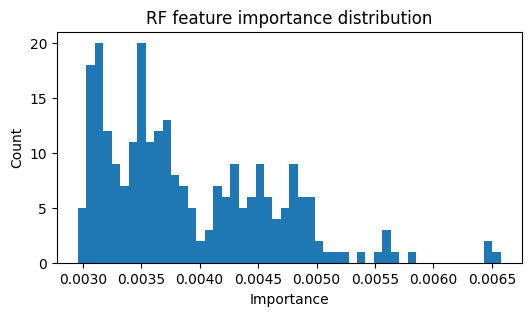

In [13]:
y_pred = rf.predict(X_rf_val)

acc = accuracy_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)

print("Random Forest accuracy:", acc)
print("\nConfusion matrix:")
print(cm)

print("\nClassification report:")
print(classification_report(y_val, y_pred, target_names=["Executed", "Imagined"]))

importances = rf.feature_importances_
plt.figure(figsize=(6,3))
plt.hist(importances, bins=50)
plt.title("RF feature importance distribution")
plt.xlabel("Importance")
plt.ylabel("Count")
plt.show()

In [14]:
param_grid = {
    "max_depth": [8, 12, 16, 20, None],
    "min_samples_leaf": [1, 5, 10, 20],
}

results = []

for max_depth, min_leaf in itertools.product(
    param_grid["max_depth"], param_grid["min_samples_leaf"]
):
    rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=max_depth,
        min_samples_leaf=min_leaf,
        n_jobs=-1,
        random_state=42,
    )
    rf.fit(X_rf_train, y_train)
    y_pred = rf.predict(X_rf_val)
    acc = accuracy_score(y_val, y_pred)

    results.append({
        "max_depth": max_depth,
        "min_samples_leaf": min_leaf,
        "accuracy": acc
    })

df_results = pd.DataFrame(results).sort_values("accuracy", ascending=False)
df_results["max_depth"] = df_results["max_depth"].where(df_results["max_depth"].notna(), "None")
df_results.head(10)

,max_depth,min_samples_leaf,accuracy
10,16.0,10,0.562795
19,NaN,20,0.562542
14,20.0,10,0.561869
8,16.0,1,0.561700
13,20.0,5,0.561279
6,12.0,10,0.561195
18,NaN,10,0.561027
17,NaN,5,0.560859
2,8.0,10,0.560774
4,12.0,1,0.560438


## 3. Convolutional Neural Network (CNN) Classification

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

class EEGWindowsDataset(Dataset):
    def __init__(self, X, y):
        # X: (N, C, T) float32
        # y: (N,) int64
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

Device: cpu


### 3.1. Data Preparation for CNN

In [28]:
from sklearn.model_selection import train_test_split

subjects = meta["subject"].unique()
train_subj, val_subj = train_test_split(subjects, test_size=0.2, random_state=42, shuffle=True)

train_mask = meta["subject"].isin(train_subj).values
val_mask = meta["subject"].isin(val_subj).values

X_train, y_train = X_cnn[train_mask], y[train_mask]
X_val, y_val     = X_cnn[val_mask], y[val_mask]

print("Train:", X_train.shape, np.bincount(y_train))
print("Val:  ", X_val.shape, np.bincount(y_val))

Train: (47740, 64, 320) [23868 23872]
Val:   (11880, 64, 320) [5940 5940]


In [29]:
batch_size = 32

train_ds = EEGWindowsDataset(X_train, y_train)
val_ds   = EEGWindowsDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)

In [36]:
class EEG1DCNN(nn.Module):
    def __init__(self, n_channels=64, n_classes=2, sampling_rate=160):
        super(EEG1DCNN, self).__init__()
        self.temporal_block = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 80), padding=(0, 40), bias=False),
            nn.BatchNorm2d(16)
        )

        self.spatial_block = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(n_channels, 1)),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.5)
        )

        self.separable_block = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1, 16), padding=(0, 8), groups=32, bias=False),
            nn.Conv2d(32, 32, kernel_size=(1, 1), bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(0.5)
        )

        # Note: Flattening size depends on your input signal length (T).
        # For a 2-second window (320 samples), the feature map size after pooling is ~10.
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 10, n_classes) 
        )

    def forward(self, x):
        # x shape: [Batch, 1, Channels, Time]
        x = self.temporal_block(x)
        x = self.spatial_block(x)
        x = self.separable_block(x)
        return self.classifier(x)

In [37]:
n_channels = X_train.shape[1]
model = EEG1DCNN(n_channels=n_channels).to(device)
print(model)

EEG1DCNN(
  (temporal_block): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 80), stride=(1, 1), padding=(0, 40), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (spatial_block): Sequential(
    (0): Conv2d(16, 32, kernel_size=(64, 1), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.5, inplace=False)
  )
  (separable_block): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=32, bias=False)
    (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (5): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Flat

In [38]:
def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = 0.0
    all_preds = []
    all_true = []

    for Xb, yb in loader:
        Xb = Xb.to(device)
        yb = yb.to(device)

        if len(Xb.shape) == 3:
            Xb = Xb.unsqueeze(1) # Changes [32, 64, 320] -> [32, 1, 64, 320]

        logits = model(Xb)

        logits = model(Xb)
        loss = nn.CrossEntropyLoss()(logits, yb)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * Xb.size(0)

        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.detach().cpu().numpy())
        all_true.append(yb.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_true = np.concatenate(all_true)

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_true, all_preds)
    return avg_loss, acc, all_true, all_preds

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

n_epochs = 15
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_acc = 0.0
best_state = None

for epoch in range(1, n_epochs + 1):
    tr_loss, tr_acc, _, _ = run_epoch(model, train_loader, optimizer=optimizer)
    va_loss, va_acc, y_true, y_pred = run_epoch(model, val_loader, optimizer=None)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    train_accs.append(tr_acc)
    val_accs.append(va_acc)

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}")

print("Best val acc:", best_val_acc)

Epoch 01 | train loss 0.6896 acc 0.544 | val loss 0.6742 acc 0.591
Epoch 02 | train loss 0.6722 acc 0.582 | val loss 0.6643 acc 0.594
Epoch 03 | train loss 0.6643 acc 0.596 | val loss 0.6619 acc 0.606
Epoch 04 | train loss 0.6580 acc 0.602 | val loss 0.6559 acc 0.609
Epoch 05 | train loss 0.6515 acc 0.614 | val loss 0.6473 acc 0.624
Epoch 06 | train loss 0.6444 acc 0.623 | val loss 0.6590 acc 0.607
Epoch 07 | train loss 0.6413 acc 0.625 | val loss 0.6408 acc 0.625
Epoch 08 | train loss 0.6336 acc 0.635 | val loss 0.6457 acc 0.619
Epoch 09 | train loss 0.6303 acc 0.638 | val loss 0.6432 acc 0.626
Epoch 10 | train loss 0.6262 acc 0.644 | val loss 0.6452 acc 0.626
Epoch 11 | train loss 0.6231 acc 0.649 | val loss 0.6471 acc 0.621
Epoch 12 | train loss 0.6202 acc 0.652 | val loss 0.6426 acc 0.622
Epoch 13 | train loss 0.6174 acc 0.655 | val loss 0.6473 acc 0.622
Epoch 14 | train loss 0.6162 acc 0.654 | val loss 0.6461 acc 0.624
Epoch 15 | train loss 0.6125 acc 0.658 | val loss 0.6497 acc 0

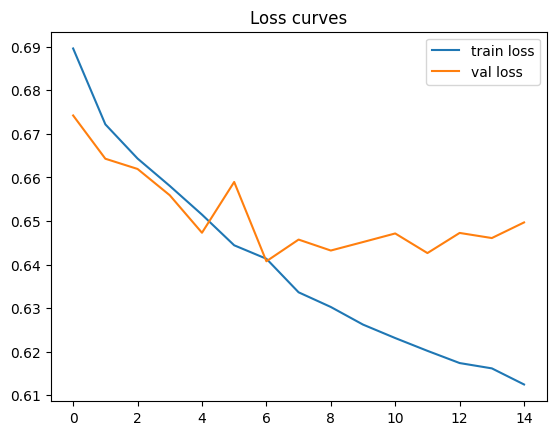

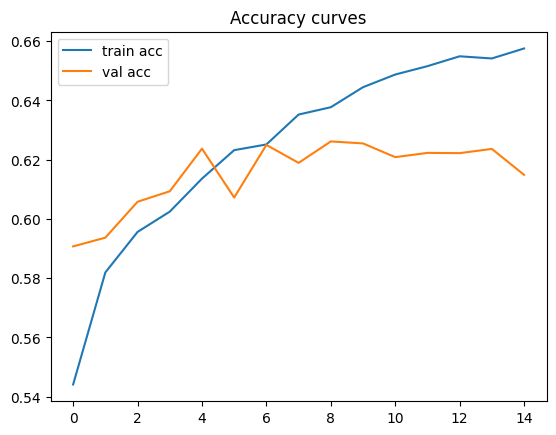

In [40]:
plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend()
plt.title("Loss curves")
plt.show()

plt.figure()
plt.plot(train_accs, label="train acc")
plt.plot(val_accs, label="val acc")
plt.legend()
plt.title("Accuracy curves")
plt.show()

In [41]:
model.load_state_dict(best_state)
va_loss, va_acc, y_true, y_pred = run_epoch(model, val_loader, optimizer=None)

print("Final val acc:", va_acc)
print("\nConfusion matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=["Executed", "Imagined"]))

Final val acc: 0.6261784511784512

Confusion matrix:
[[4661 1279]
 [3162 2778]]

Classification report:
              precision    recall  f1-score   support

    Executed       0.60      0.78      0.68      5940
    Imagined       0.68      0.47      0.56      5940

    accuracy                           0.63     11880
   macro avg       0.64      0.63      0.62     11880
weighted avg       0.64      0.63      0.62     11880

